# Machine Learning Homework 3

## Instructions

**Completing the homework:**  Follow along with the text and code in the notebook from start to finish.  There are two parts and 5 graded questions, worth a total of 5 points.  While some code is provided for you in the notebook, there are two types of work left for you:
- **Tasks:** This work is meant to help you better understand the course material an will help you answer the questions.  Importantly, this work is not graded.  Tt is optional, but highly recommended.
- **Questions:** These are the questions you need to answer and that are graded.
    
**How to turn in the homework**:  You need to make **two different Moodle submissions**.  First, you must open the Moodle Homework 3 Answers resources and answer the questions exactly how they correspond to those found in the Notebook.  Second, you must upload your notebook to the Moodle Homework 3 Notebook Upload.

This homework is due **before class on Monday, May 10.**

## Imports

Below are the all the imports you will need to complete the homework.  You may use additional libraries if you desire, but they should not be needed.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

import pandas as pd
import seaborn as sns
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
from aequitas.plotting import Plot

import shap
import xgboost

import warnings; warnings.simplefilter('ignore')

%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from matplotlib import pyplot as plt
%matplotlib inline

import warnings

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
warnings.filterwarnings("ignore") 

# Bias and Fairness

## Choosing a fairness metric

Consider the following scenario:

Suppose a certain country in Europe is building a model to predict the risk that a criminal is going to recidivate, similiar to the prediction made by the COMPAS model discussed in class.  However, in contrast to COMPAS, the goal is not to use these scores to determine whether or not an individual is allowed to be free; instead, those individuals with a high risk score will be admitted into a special program.  The special program has three components:  (1) the individuals recieve one-on-one counseling, (2) the individuals will recieve a monthly stipend, and (3) the individuals are set up with housing.  The program is a benefit to the individuals and is aimed at reducing recividism.

**Task:**  Consider the confusion matrix for the model.  How would you interpret the true positive, false positives, true negatives, and false negatives?

**Answer:** <br>
True positive: We predict that he/she recidivate and he/she indeed would without any intervention. We might prevent him/her from recidivating with the benefits. <br>
False positive: We predict that he/she would recidivate, but indeed he/she would not. The benefits we give to him/her do not prevent recidivation and would be wasted tax money with respect to the goal of the expense.

True negative: We predict that he/she does not recividate and indeed he/she does not. We do not give him/her benefits and its all good. <br>
False negative: We predict that he/she does not recidivate although in reality he/she does. We could have prevented the crime he/she comits by granting him/her the benefits.

The country is trying to decide on the proper fairness metric to use for their machine learning model, and cares about the protected attribute race.  In terms of representation, they would either accept a model that has equal nominal representation of different races, or equal proportional representation in the special program.  They are also concerend about errors made by the model, and want to make sure that predictive equity among groups is acheieved for people with need.

**Task:**  Review the Aequitas guidelines for fairness metrics, and think about them in the context of this problem:  http://www.datasciencepublicpolicy.org/projects/aequitas/.

**Question 1 (1 pt):** Which of the following is NOT a good choice for a fairness metric for the model?

> a) False Negative Rate Parity \
> b) Minimizing Disparate Impact \
> c) Demographic Parity \
> x d) False Discovery Rate Parity

## Auditing and mitigating bias

We will now work on a machine learning problem related to student educational outcomes.  The goal of Part 1 of this  homework assignment is to build a model that can accurately predict whether or not a student will pass their final year of high school, and audit that model for bias.

The data we will use contains **student achievement in high school** for students enrolled in two Portuguese schools. The data features include **student grades, demographics, social and school-related features** and it was collected by using school reports and questionnaires [Cortez and Silva, 2008].  This data comes from a study carried about by Paulo Cortez at the University of Minho, located in Guimaraes, Portugal.  More information on the data and the problem can be found here:   https://www.kaggle.com/dipam7/student-grade-prediction.

The **business context** of this problem is building a machine learning model that can accurately predict if a student will fail their final year of secondary education, so that they may be enrolled pre-emptively into remedial courses.

In [2]:
X = pd.read_csv("matrices/X.csv",index_col=0)
y = pd.read_csv("matrices/y.csv",index_col=0,squeeze = True)

In [3]:
X.head()

,absences,failures,grade1,traveltime,studytime,famrel,freetime,goout,Dalc,Walc,health,activities,nursery,internet,romantic,school_gp,address_urban,famsize_gt3,Pstatus_togethor,sex_female,health_mjob,other_mjob,services_mjob,teacher_mjob,health_fjob,other_fjob,services_fjob,teacher_fjob,home_reason,other_reason,reputation_reason,mother_guardian,other_guardian
0,12,0,15,1,1,3,2,1,1,4,5,0,1,1,0,1,1,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0
1,2,0,17,1,2,5,3,4,1,3,3,1,0,1,0,1,1,1,1,1,0,1,0,0,0,1,0,0,0,0,0,1,0
2,0,2,9,2,1,4,4,5,3,5,5,0,0,1,0,1,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0
3,4,0,14,2,2,4,4,3,1,1,3,1,1,1,0,0,1,1,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0
4,2,0,12,2,1,4,3,2,1,4,5,0,1,0,0,1,1,1,1,1,0,0,0,0,0,1,0,0,1,0,0,1,0


Now we will divide the data into training and testing data using the sklearn `train_test_split` function.

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

**Task**:  Train a Random Forest Classifier (https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) for this data.  Use the hyperparmeters `max_depth=6, n_estimators=100,random_state=42` when training the classifier.

In [5]:
RandomForest = RandomForestClassifier(n_estimators = 100, max_depth = 6, random_state=42)
RandomForest.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, random_state=42)

**Task:** Print out and plot the feature importance of the RandomForestClassifier.  What is the most important feature?  What is the least important feature?  Do you notice any feature importance that may indicate bias in the model?

In [20]:
feature_imprtnc = dict(zip(X.columns, RandomForest.feature_importances_))

In [21]:
feature_imprtnc

{'absences': 0.08165817564711951,
 'failures': 0.09316393898870437,
 'grade1': 0.43680732085213203,
 'traveltime': 0.016379253354668232,
 'studytime': 0.020109998092071067,
 'famrel': 0.03266078053334526,
 'freetime': 0.02217689727099665,
 'goout': 0.034817207564433766,
 'Dalc': 0.021827077037824768,
 'Walc': 0.02357554412441934,
 'health': 0.02462119426146109,
 'activities': 0.008763914485614933,
 'nursery': 0.007754376555521284,
 'internet': 0.015244349874225373,
 'romantic': 0.013765839666429832,
 'school_gp': 0.016588723596342992,
 'address_urban': 0.012108844617909533,
 'famsize_gt3': 0.010027242335080535,
 'Pstatus_togethor': 0.005546063341417193,
 'sex_female': 0.007148121943724799,
 'health_mjob': 0.0025829551236134746,
 'other_mjob': 0.009053798062316489,
 'services_mjob': 0.006633079180204706,
 'teacher_mjob': 0.005750418339734966,
 'health_fjob': 0.0012869067920734142,
 'other_fjob': 0.010971588346056726,
 'services_fjob': 0.013722787946560169,
 'teacher_fjob': 0.00331485876

In [15]:
min_imprtnc = min(RandomForest.feature_importances_)
max_imprtnc = max(RandomForest.feature_importances_)
min_imprtnc_ix = list(RandomForest.feature_importances_).index(min_imprtnc)
max_imprtnc_ix = list(RandomForest.feature_importances_).index(max_imprtnc)
min_imprtnc_feature = list(X.columns)[min_imprtnc_ix]
max_imprtnc_feature = list(X.columns)[max_imprtnc_ix]

In [18]:
print(f"Most important feature: {max_imprtnc_feature} ({max_imprtnc})\nLeast important feature: {min_imprtnc_feature} ({min_imprtnc})") 

Most important feature: grade1 (0.43680732085213203)
Least important feature: health_fjob (0.0012869067920734142)


In [25]:
print(f"sex_female has an importance of {feature_imprtnc['sex_female']}. This value is comparably low, but surely not nothing - ceteris paribus, females will be treated different than males.")

sex_female has an importance of 0.007148121943724799. This value is comparably low, but surely not nothing - ceteris paribus, females will be treated different than males.


**Question 2 (1 pt):** What is the feature importance for the variable `sex_female`?

> a) `0.01` \
> x b) `0.007`  \
> c) `0.09` \
> d) `0.436`

**Task:** Based on the feature importance of the `sex_female` variable, do you think it has a significant impact on the output of the model?  Reflect on whether or not this means there will be bias present in the model.

Regardless, it is important that we conduct a more *robust* bias audit of our model.  To do this, we will use the tool Aequitas.

Before we begin, we must first select a fairness metric.  There are several choices that woud make sense (take some time to reflect on these on your own), but for the purposes of this notebook, we will focus on the **False Negative Rate**.

Consider the **False Negative** in this context:  a FN is a student that the model predicts will *not* recieve a failing grade, when in reality, they would.  Had they been desiginated as high risk, they would have recieved accesss to the special intervention that is part of our business context.

To put this another way, a False Negative Rate disparity between groups would indicate that we were disproportionately *missing out* on desiginating individuals from one group who needed help for special intervention, compared to another other groups.

**Task:** Follow along with the Aequitas documentation to find the False Negative Rates of the males and females for your model:  https://dssg.github.io/aequitas/examples/compas_demo.html

*Note:* Aequitas requires some pre-processing to run properly; that has been done for you in the code cell below and the pre-processed dataset is stored in the variable `df`.

In [26]:
aequitas = X_train.filter(items=["sex_female"])
aequitas["sex"] = aequitas["sex_female"].apply(lambda x: "F" if x == 1 else "M")
aequitas["label_value"] = y_train
y_pred_train = RandomForest.predict(X_train)
aequitas["score"] = y_pred_train
df = aequitas.drop(columns=["sex_female"])

df.head(5)

,sex,label_value,score
497,F,1,1
326,F,1,1
144,F,1,1
545,M,1,0
622,M,0,0


**Task:** Calculate the False Negative Rate disparity of the model using the formula `FNR_female / FNR_male`.  What does this value represent?  When would the disparity be equal to `1.0`?  What does a disparity less than `1.0` mean?  What does a disparity greater than `1.0` mean?

In [27]:
g = Group()
xtab, _ = g.get_crosstabs(df)

In [28]:
xtab

,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev
0,0,binary 0/1,99,sex,F,0.753247,0.993243,0.060703,0.033333,0.006757,0.246753,0.939297,0.966667,60,313,0.606061,0.160858,2,19,294,58,77,296,373,626,0.206434
1,0,binary 0/1,99,sex,M,0.696429,1.000000,0.079439,0.000000,0.000000,0.303571,0.920561,1.000000,39,214,0.393939,0.154150,0,17,197,39,56,197,253,626,0.221344


In [12]:
xtab['fnr'][0] / xtab['fnr'][1]

0.8128342245989305

In [38]:
print("Females have fewer false negatives - i.e. predicting pass although they fail - than males. The model is less friendly towards women")

Females have fewer false negatives - i.e. predicting pass although they fail - than males. The model is less friendly towards women


In [13]:
b = Bias()

In [14]:
bdf = b.get_disparity_predefined_groups(xtab, original_df=df, ref_groups_dict={'sex':'M'}, alpha=0.05, mask_significance=True)
bdf.style

get_disparity_predefined_group()


,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity,ppr_ref_group_value,pprev_ref_group_value,precision_ref_group_value,fdr_ref_group_value,for_ref_group_value,fpr_ref_group_value,fnr_ref_group_value,tpr_ref_group_value,tnr_ref_group_value,npv_ref_group_value
0,0,binary 0/1,99,sex,F,0.753247,0.993243,0.060703,0.033333,0.006757,0.246753,0.939297,0.966667,60,313,0.606061,0.160858,2,19,294,58,77,296,373,626,0.206434,1.538462,1.043514,0.966667,10.000000,0.764142,10.000000,0.812834,1.081585,0.993243,1.020353,M,M,M,M,M,M,M,M,M,M
1,0,binary 0/1,99,sex,M,0.696429,1.000000,0.079439,0.000000,0.000000,0.303571,0.920561,1.000000,39,214,0.393939,0.154150,0,17,197,39,56,197,253,626,0.221344,1.000000,1.000000,1.000000,nan,1.000000,nan,1.000000,1.000000,1.000000,1.000000,M,M,M,M,M,M,M,M,M,M


**Question 3 (1 pt):** Approximately what is the False Negative Rate disparity of the RandomForestClassifier?

> a) `1.2` \
> b) `1.0` \
> x c) `0.8`  \
> d) `0.6`

**Task:**  Reflect on your answer for Question 3.  Do you think the model is equitable to both males and females?  Generally, as a rule-of-thumb, we accept disparities between `0.85` and `1.15` as fair.

**Task:** First, train a new RandomForestClassifier using the same hyperparameters as earlier (and remember to use `random_state=42`), but this time, drop the feature `sex_female` from the train and test matrices.  Second, carry out the same Aequitas analysis as before and find the FNR disparity between the males and females.

In [30]:
sex_female = X_train['sex_female']
X_train.drop(columns = 'sex_female', inplace = True)
RandomForest = RandomForestClassifier(n_estimators = 100, max_depth = 6, random_state=42)
RandomForest.fit(X_train, y_train)
X_train['sex_female'] = sex_female

In [31]:
aequitas = X_train.filter(items=["sex_female"])
aequitas["sex"] = aequitas["sex_female"].apply(lambda x: "F" if x == 1 else "M")
aequitas["label_value"] = y_train
X_train.drop(columns = 'sex_female', inplace = True)
y_pred_train = RandomForest.predict(X_train)
aequitas["score"] = y_pred_train
df = aequitas.drop(columns=["sex_female"])

df.head(5)

,sex,label_value,score
497,F,1,1
326,F,1,1
144,F,1,1
545,M,1,0
622,M,0,0


In [32]:
g = Group()
xtab, _ = g.get_crosstabs(df)
xtab['fnr'][0] / xtab['fnr'][1]

0.8636363636363636

**Question 4 (1 pt):** Approximately what is the False Negative Rate disparity of the RandomForestClassifier trained without the `sex_female` feature?

> a) `1.2` \
> b) `1.05` \
> x c) `0.85` \
> d) `0.60`

**Task:** Reflect on the answer you found to Question 4.  Is the model more fair, or less fair?  Would you be comfortable deploying this model into the real world?  What would you say to someone concerned about the fairness of the model with respect to gender?  Could you defend the decision in a way that many different stakeholders - like policymakers, educators, students affected by the model, and even society-at-large - would see it as fair and just?

What is the performance of the new model?  Was there a tradeoff between model performance and fairness?

## Explainability

Before deploying our model into production, we should gain some insight on *how* it is working, and *why* it is scoring the students the way it is.

To do this, we will use the **black-box explainer SHAP**.  This is a post-hoc explainability method, meaning that is applied *after* our model has been trained.

Before we begin explaining, we will train a commonly used black-box model for our data called XGBoost.

**Task:**  Train an XGBoost model using the hyperparemters `n_estimators=200, max_depth=5, random_state=42`.  Inspect the models performance and compare it to the Random Forest models we used earlier.

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [44]:
clf = xgboost.XGBClassifier(n_estimators=200, max_depth=5,random_state=42)
clf.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=200,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [45]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_test)

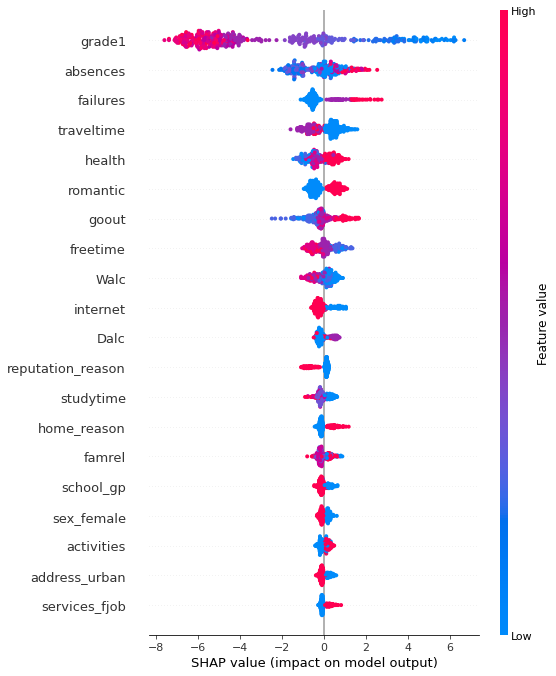

In [46]:
shap.summary_plot(shap_values, X_test, plot_type='dot')

**Task:** Import the `shap` package and construct and use the `TreeExplainer` method to create a `summary_plot` (use the dot representation) for the XGBoost Classifier you just trained.

*Note: you will want to use shap_vales instead of shap_values[1] as the first parameter.*

**Task:** Reflect on the meaning of the plot.  What does each dot represent?  What do the color of the dots represent?  What is the impact on the model output?

**Answer:** This plot is basically a map, relating for each observation the value of a feature to the prediction output. Like this, we can get a notion of of how a certain input to the model will look in the output of the model. In this specific case, we observe that grade1 plays the major role on determining the prediction of the model. A high grade1 will make the model less likely to predict failure. 

**Question 5 (1 pt):** What is the most important feature of the XGBoost Classifier, and what impact does it have on the model output when its' values are high?

> a) `grade1`, positive \
> x b) `grade1`, negative \
> c) `failures`, positive \
> d) `failures`, negative

**Task:** Audit the XGBoost model for bias.

In [55]:
aequitas = X_train.filter(items=["sex_female"])
aequitas["sex"] = aequitas["sex_female"].apply(lambda x: "F" if x == 1 else "M")
aequitas["label_value"] = y_train
y_pred_train = clf.predict(X_train)
aequitas["score"] = y_pred_train
df = aequitas.drop(columns=["sex_female"])

df.head(5)

,sex,label_value,score
497,F,1,1
326,F,1,1
144,F,1,1
545,M,1,1
622,M,0,0


In [56]:
g = Group()
xtab, _ = g.get_crosstabs(df)
xtab['fnr'][0] / xtab['fnr'][1]

1.4545454545454548

In [57]:
xtab

,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev
0,0,binary 0/1,130,sex,F,0.974026,1.0,0.006711,0.0,0.0,0.025974,0.993289,1.0,75,298,0.576923,0.201072,0,2,296,75,77,296,373,626,0.206434
1,0,binary 0/1,130,sex,M,0.982143,1.0,0.005051,0.0,0.0,0.017857,0.994949,1.0,55,198,0.423077,0.217391,0,1,197,55,56,197,253,626,0.221344


In [59]:
print('Biased into the other direction! Hoever, this is based on very few false predictions, so you cant really say that there is a bias here, although the FNR disparity is relatively high.')

Biased into the other direction! Hoever, this is based on very few false predictions, so you cant really say that there is a bias here, although the FNR disparity is relatively high.
